In [19]:
torch.cuda.is_available()

True

In [1]:
import time
import numpy as np
import os, glob
import cv2
import torch
from torchvision import transforms
from yolo.models.experimental import attempt_load
from yolo.utils.general import non_max_suppression,scale_coords
from yolo.utils.torch_utils import  TracedModel
from yolo.weight.rec.model import CNN
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
torch.cuda.is_available()

In [2]:
imgsz = 416
conf_thres=0.3
iou_thres=0.45
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weights_crop = ['yolo/weight/crop/best.pt']
model_crop = attempt_load(weights_crop, map_location=device) 
stride_crop = int(model_crop.stride.max())
model_crop = TracedModel(model_crop, device, imgsz)
model_crop.half()
model_crop(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model_crop.parameters())))
model_crop.eval()

imgsz = 416
conf_thres=0.5
iou_thres=0.45
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weights_seg = ['yolo/weight/seg/best.pt']
model_seg = attempt_load(weights_seg, map_location=device) 
stride_seg = int(model_seg.stride.max())
model_seg = TracedModel(model_seg, device, imgsz)
model_seg.half()
model_seg(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model_seg.parameters())))
model_seg.eval()

LABEL_DICT = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'P', 25: 'Q', 26: 'R', 27: 'S', 28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 33: 'Y', 34: 'Z', 35: '2', 36: '3', 37: '6', 38: '9', 39: 'B', 40: 'K', 41: 'R'}
model_rec = CNN()
model_rec.load_state_dict(torch.load("yolo/weight/rec/model.pt"))
model_rec.eval()
convert_tensor = transforms.ToTensor()


Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



In [3]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [4]:
def predict(model,stride, origin_img):
    # cv2.imshow('My Image', origin_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    img = letterbox(origin_img, imgsz, stride=stride)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half()
    img /= 255.0 
    img = img.unsqueeze(0)
    
    # with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
    pred = model(img, augment=True)[0]
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes=None, agnostic=False)[0]
    pred = [pred[pred[:, 0].sort(descending=True)[1]]]
    
    output = {
        "box":list(),
        "image":list(),
    }
    for i, det in enumerate(pred):
        if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], origin_img.shape).round()
            for *xyxy, conf, cls in reversed(det):
                c1, c2 = (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3]))
                output["box"].append([c1,c2])
                output["image"].append(origin_img[c1[1]:c2[1], c1[0]:c2[0]])
            
    return output

In [5]:
def predict_rec(img):
    img = cv2.resize(img, (32, 32))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV) 
    img_tensor = convert_tensor(img)
    img_tensor = torch.unsqueeze(img_tensor, dim = 1)
    predic_label, predict_img = model_rec(img_tensor)
    predict = torch.max(predic_label, 1)[1].item()
    # print("predict : " + str(LABEL_DICT[predict]))
    return str(LABEL_DICT[predict])

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

crop done !!!
seg done !!!
Car Plate License : BCC2035
predict process time : 0.030482053756713867
[(854, 565), (949, 614)]


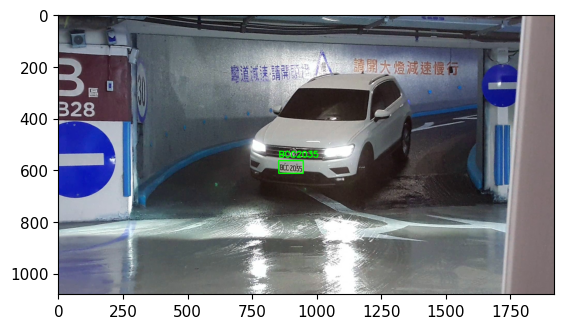

In [18]:
img_list = img_list = sorted(glob.glob(os.path.join("yolo/*.jpg")))
for index, img in enumerate(img_list):
    # img = "datasets_seg/images/2022_00001.jpg"
    origin_img = cv2.imread(img)

    start = time.time()
    # crop the car plate license
    crop_output = predict(model_crop, stride_crop,origin_img)
    print("crop done !!!")
    
    # segment the car plate license
    for crop_img in crop_output["image"]:
        seg_output = predict(model_seg, stride_seg,crop_img)
    print("seg done !!!")

    # predict the word
    rec_output = ""
    for seg_img in seg_output["image"]:
        rec_output += predict_rec(seg_img)
    
    print("Car Plate License : " + rec_output)
    print("predict process time : " + str(time.time()-start))


    # 顯示圖片
    for crop_box in crop_output["box"]:
        print(crop_box)
        x1, y1, x2, y2 = crop_box[0][0], crop_box[0][1], crop_box[1][0], crop_box[1][1]
        cv2.rectangle(origin_img, crop_box[0], crop_box[1], (0, 255, 0), 3)
        cv2.putText(origin_img, "{}".format(rec_output), (x1, y1 - 13), cv2.FONT_HERSHEY_SIMPLEX,
                    1e-3 * origin_img.shape[0], (0, 255, 0), 4)
    
        plt.imshow(origin_img)
        plt.show()
       
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
#         cv2.imwrite('./yolo/image.jpg',origin_img)
    break

In [5]:
list1 = [1,2,3,4]
list2 = [1,2,3,4]
list3 = [1,2,3,4]

for i, ii ,iii in zip(list1,list2,list3):
    print(i, ii ,iii)

1 1 1
2 2 2
3 3 3
4 4 4


In [1]:
from yolo.yolo_predict import YoloPredict
yp = YoloPredict()

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


第一個模型成功
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

第二個模型成功
第三個模型成功
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

第四個模型成功


In [2]:
import cv2
img = yp.predict_default(cv2.imread("./yolo/00011.jpg"))

predict process time : 0.06342864036560059


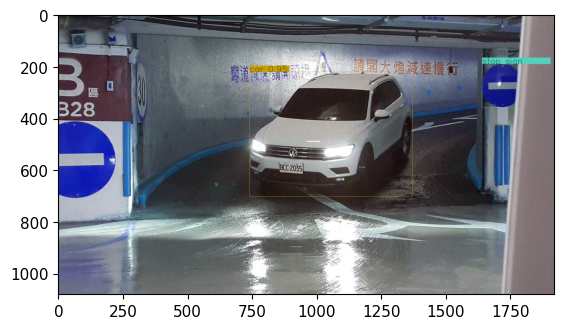

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()